# Linear Regression

The workhorse of empirical research in the social sciences

In [1]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import pyrsm as rsm

# increase plot resolution
mpl.rcParams["figure.dpi"] = 150
rsm.__version__

'0.8.1'

In [2]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

### Example 1: Catalog sales

We have access to data from a company selling men's and women's apparel through mail-order catalogs (dataset `catalog`). The company maintains a database on past and current customers' value and characteristics. Value is determined as the total \$ sales to the customer in the last year.

The catalog company is interested in redesigning their Customer Relationship Management (CRM) strategy. We will proceed in two steps:

1. Estimate a regression model using last year's sales total. Response variable: sales total for each of the 200 households; Explanatory variables: household income (measured in thousands of dollars), size of household, and age of the household head.
2. Interpret each of the estimated coefficients. Also provide a statistical evaluation of the model as a whole.
3. Which explanatory variables are significant predictors of customer value (use a 95% confidence level)?


In [3]:
# load example data from the pyrsm library
rsm.load_data(pkg="model", name="catalog", dct=globals())

In [4]:
# each dataset in the pyrsm library has a description attached 
# use the function below to show the description
rsm.describe(catalog)

## Catalog sales

### Description

Data from a company selling men's and women's apparel through mail-order catalogs. The company maintains a database on past and current customers' value and characteristics. Value is determine as the total $ sales to the customer in the last year. The data are a random sample of 200 customers from the company's database.

### Variables

A data frame with 200 observations on 4 variables

- id = Customer id
- Sales =	Total sales (in $) to a household in the past year
- Income = Household income ($1000) 
- HH.size = Size of the household (# of people) 
- Age = Age of the head of the household

In [5]:
reg = rsm.regress(catalog, rvar="Sales", evar=["Income", "HH_size", "Age"])

In [6]:
reg.summary(ssq=True)

Linear regression (OLS)
Data                 : Not provided
Response variable    : Sales
Explanatory variables: Income, HH_size, Age
Null hyp.: the effect of x on Sales is zero
Alt. hyp.: the effect of x on Sales is not zero

    index  coefficient  std.error  t.value p.value    
Intercept        45.36     43.089    1.053   0.294    
   Income         1.78      0.217    8.181  < .001 ***
  HH_size        22.12      4.190    5.279  < .001 ***
      Age         0.45      0.768    0.585   0.559    

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-squared: 0.331, Adjusted R-squared: 0.321
F-statistic: 32.325 df(3, 196), p.value < 0.001
Nr obs: 200

Sum of squares:

             df         SS
Regression    3    770,565
Error       196  1,557,415
Total       199  2,327,980


The null and alternate hypothesis for the F-test can be formulated as follows:

* $H_0$: All regression coefficients are equal to 0
* $H_a$: At least one regression coefficient is not equal to zero

The F-statistic suggests that the regression model as a whole explains a significant amount of variance in `Sales`. The calculated F-statistic is equal to 32.33 and has a very small p.value (< 0.001). The amount of variance in sales explained by the model is equal to 33.1% (see R-squared).

We can replicate the standard F-test that is reported as part of all regression output by passing `income`, `HH.size`, and `Age` to the `f_test` method. The relevant output is shown below.

In [7]:
reg.f_test(["Income", "HH_size", "Age"])

Model 1: Sales ~ 1
Model 2: Sales ~ Income + HH_size + Age
F-statistic: 32.325 df (3, 196), p.value < .001


Note that in this example, "model 1" is a regression without explanatory variables. As you might expect, the explained variance for model 1 is equal to zero. The F-test compares the _fit_ of model 1 and model 2, adjusted for the difference in the number of coefficients estimated in each model. The test statistic to use is described below. $R^2_2$ is the explained variance for model 2 and $R^2_1$ is the explained variance for model 1. $n$ is equal to the number of rows in the data, and $k_2$ ($k_1$) is equal to the number of estimated coefficients in model 2 (model 1).

$$
\begin{align}
  F & = \frac{(R^2_2 - R^2_1)/(k_2 - k_1)}{(1 - R^2_2)/(n - k_2 - 1)} \\
    & = \frac{(0.331 - 0)/(3 - 0)}{(1 - 0.331)/(200 - 3 - 1)} \\
    & = 32.325
\end{align}
$$

We can use the provided p.value associated with an F-statistic of 32.325 to evaluate the null hypothesis. We can also calculate the critical F-statistic using the probability calculator. As we can see from the output below that value is 2.651. Because the provided p.value is < 0.001 and the calculated F-statistic is larger than the critical value (32.325 > 2.651) we reject null the hypothesis that all coefficient are equal to zero.

Probability calculator
Distribution: F
Df 1        : 3
Df 2        : 196
Mean        : 1.01
Variance    : 0.698
Lower bound : 0
Upper bound : 0.95

P(X < 2.651) = 0.95
P(X > 2.651) = 0.05


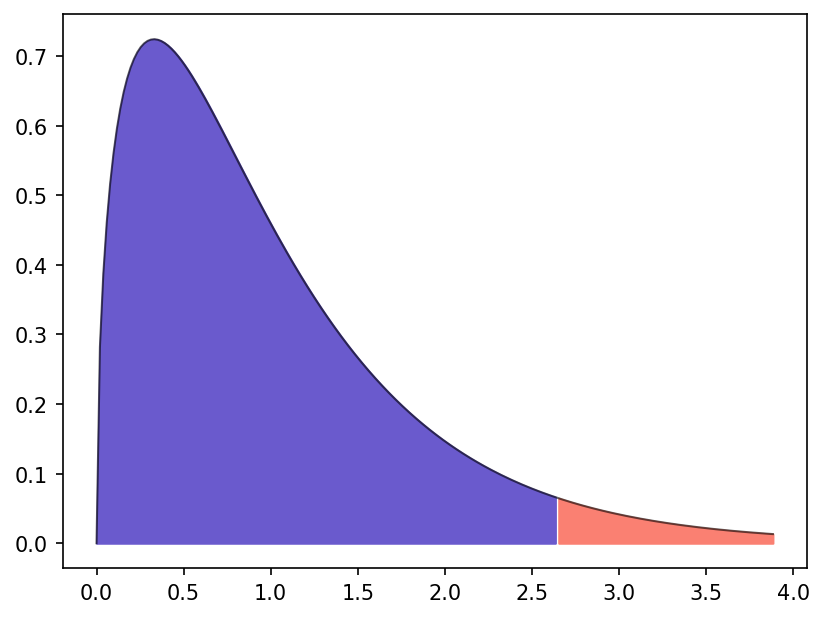

In [8]:
params = {"df1": 3, "df2": 196, "lb": 0, "ub": 0.95}
pcf = rsm.prob_calc("F", params)
pcf.summary()
pcf.plot()

The coefficients from the regression can be interpreted as follows:

- For an increase in income of \$1000 we expect, on average, to see an increase in sales of \$1.7754, keeping all other variables in the model constant.
- For an increase in household size of 1 person we expect, on average, to see an increase in sales of \$22.1218, keeping all other variables in the model constant.
- For an increase in the age of the head of the household of 1 year we expect, on average, to see an increase in sales of \$0.45, keeping all other variables in the model constant.

For each of the explanatory variables the following null and alternate hypotheses can be formulated:

* H0: The coefficient associated with explanatory variable x is equal to 0
* Ha: The coefficient associated with explanatory variable x is not equal to 0

The coefficients for `Income` and `HH.size` are both significant (p.values < 0.05), i.e., we can reject H0 for each of these coefficients. The coefficient for `Age HH` is not significant (p.value > 0.05), i.e., we cannot reject H0 for `Age HH`. We conclude that a change in Age of the household head does not lead to a significant change in sales.

We can also use the t.values to evaluate the null and alternative hypotheses for the coefficients. Because the calculated t.value for `Income` and `HH.size` is **larger** than the _critical_ t.value we reject the null hypothesis for both effects. We can obtain the critical t.value by using the probability calculator in the _Basics_ menu. For a t-distribution with 196 degrees of freedom (see the `Errors` line in the `Sum of Squares` table shown above) the critical t.value is 1.972. We have to enter 0.025 and 0.975 as the lower and upper probability bounds in the probability calculator because the alternative hypothesis is `two.sided`.

Probability calculator
Distribution: t
Df          : 196
Mean        : 0.0
St. dev     : 1.005
Lower bound : 0.025
Upper bound : 0.975

P(X < -1.972) = 0.025
P(X > -1.972) = 0.975
P(X < 1.972) = 0.975
P(X > 1.972) = 0.025
P(-1.972 < X < 1.972) = 0.95
1 - P(-1.972 < X < 1.972) = 0.05


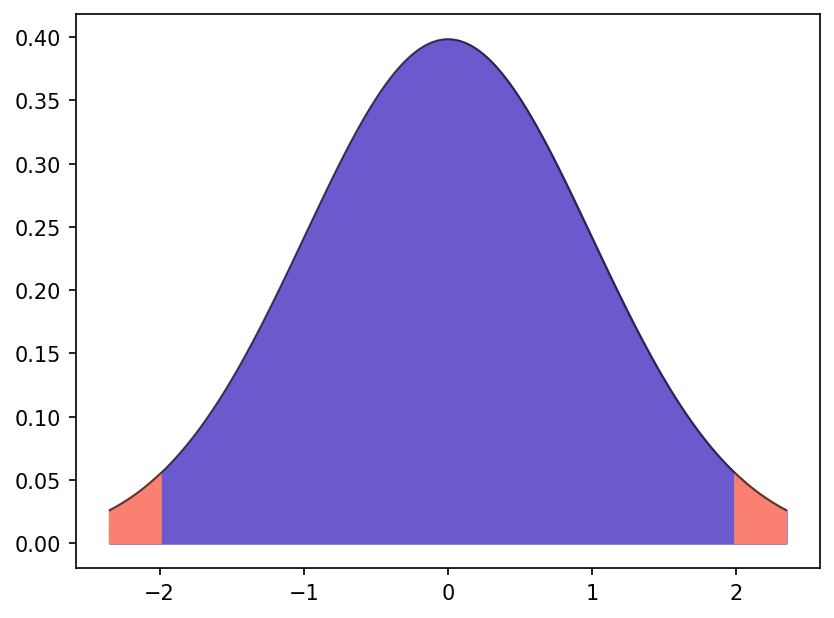

In [9]:
params = {"df": 196, "lb": 0.025, "ub": 0.975}
pct = rsm.prob_calc("t", params)
pct.summary()
pct.plot()

### Example 2: Ideal data for regression

The data `ideal` contains simulated data that is very useful to demonstrate what data for, and residuals from, a regression should ideally look like. The data has 1,000 observations on 4 variables. `y` is the response variable and `x1`, `x2`, and `x3` are explanatory variables. The plots shown below can be used as a bench mark for regressions on real world data

In [10]:
rsm.load_data(pkg="model", name="ideal", dct=globals())

In [11]:
rsm.describe(ideal)

## 'Ideal' data for regression

### Description

Simulated data set used to illustrate evaluation of regression residuals.  

### Variables

A data frame with 1000 observations on 4 variables (y, x1, x2, and x3)

`y`, `x2`, and `x3` appear (roughly) normally distributed whereas `x1` appears (roughly) uniformly distributed. There are no indication of outliers or severely skewed distributions.

In [12]:
reg = rsm.regress(ideal, rvar="y", evar=["x1", "x2", "x3"])

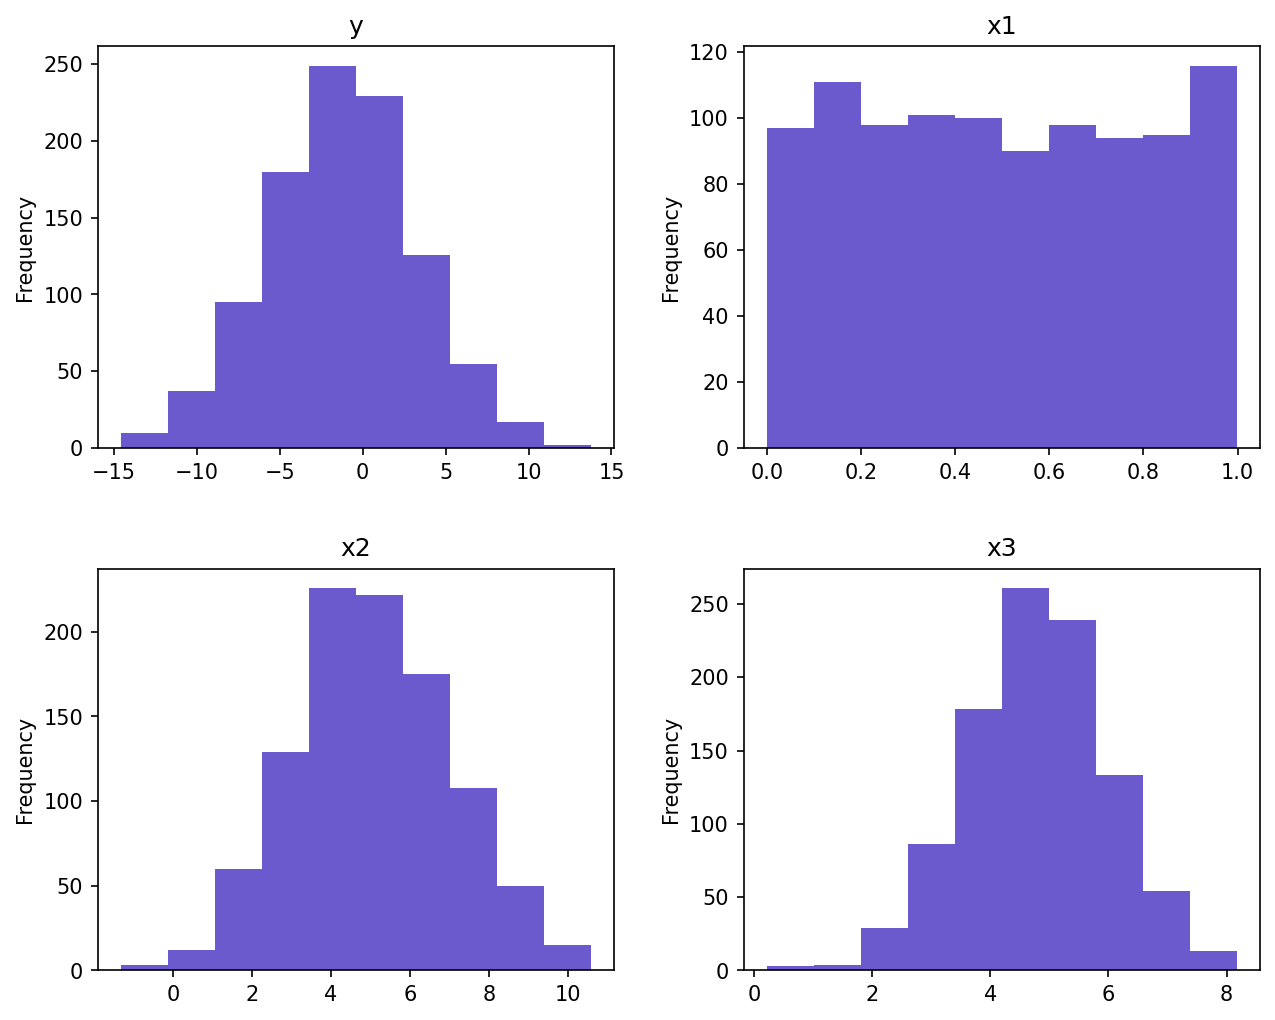

In [13]:
# rsm.distr_plot(ideal)
reg.plot("distr")

In the plot of correlations there are clear associations among the response and explanatory variables as well as among the explanatory variables themselves. Note that in an experiment the x’s of interest would have a zero correlation. This is very unlikely in historical data however. The scatter plots in the lower-diagonal part of the plot show that the relationships between the variables are (approximately) linear.

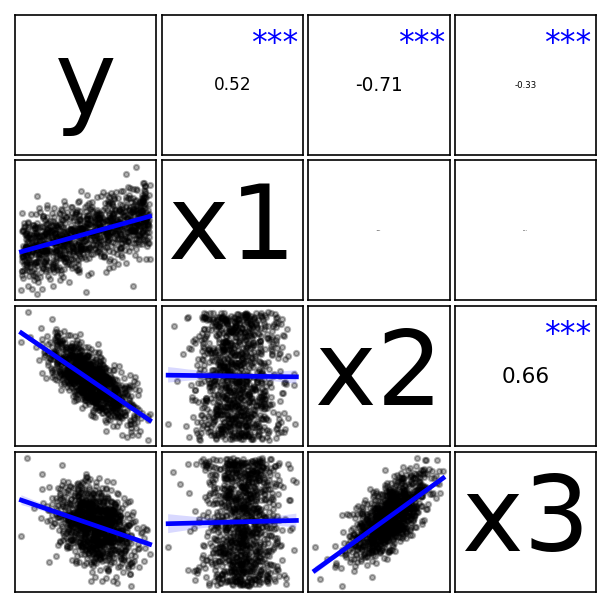

In [14]:
# cr = rsm.correlation(ideal)
# cr.plot(nobs=-1)
reg.plot("corr")

The scatter plots of `y` (the response variable) against each of the explanatory variables confirm the insight from the correlation plot. The line fitted through the scatter plots is sufficiently flexible that it would pickup any non-linearities. The lines are, however, very straight, suggesting that a linear model will likely be appropriate.

In [15]:
reg = rsm.regress(ideal, rvar="y", evar=["x1", "x2", "x3"])
reg.summary()

Linear regression (OLS)
Data                 : Not provided
Response variable    : y
Explanatory variables: x1, x2, x3
Null hyp.: the effect of x on y is zero
Alt. hyp.: the effect of x on y is not zero

    index  coefficient  std.error  t.value p.value    
Intercept         0.67      0.279    2.398   0.017   *
       x1         7.71      0.213   36.157  < .001 ***
       x2        -1.99      0.043  -46.369  < .001 ***
       x3         0.90      0.070   12.861  < .001 ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-squared: 0.804, Adjusted R-squared: 0.803
F-statistic: 1360.646 df(3, 996), p.value < 0.001
Nr obs: 1,000


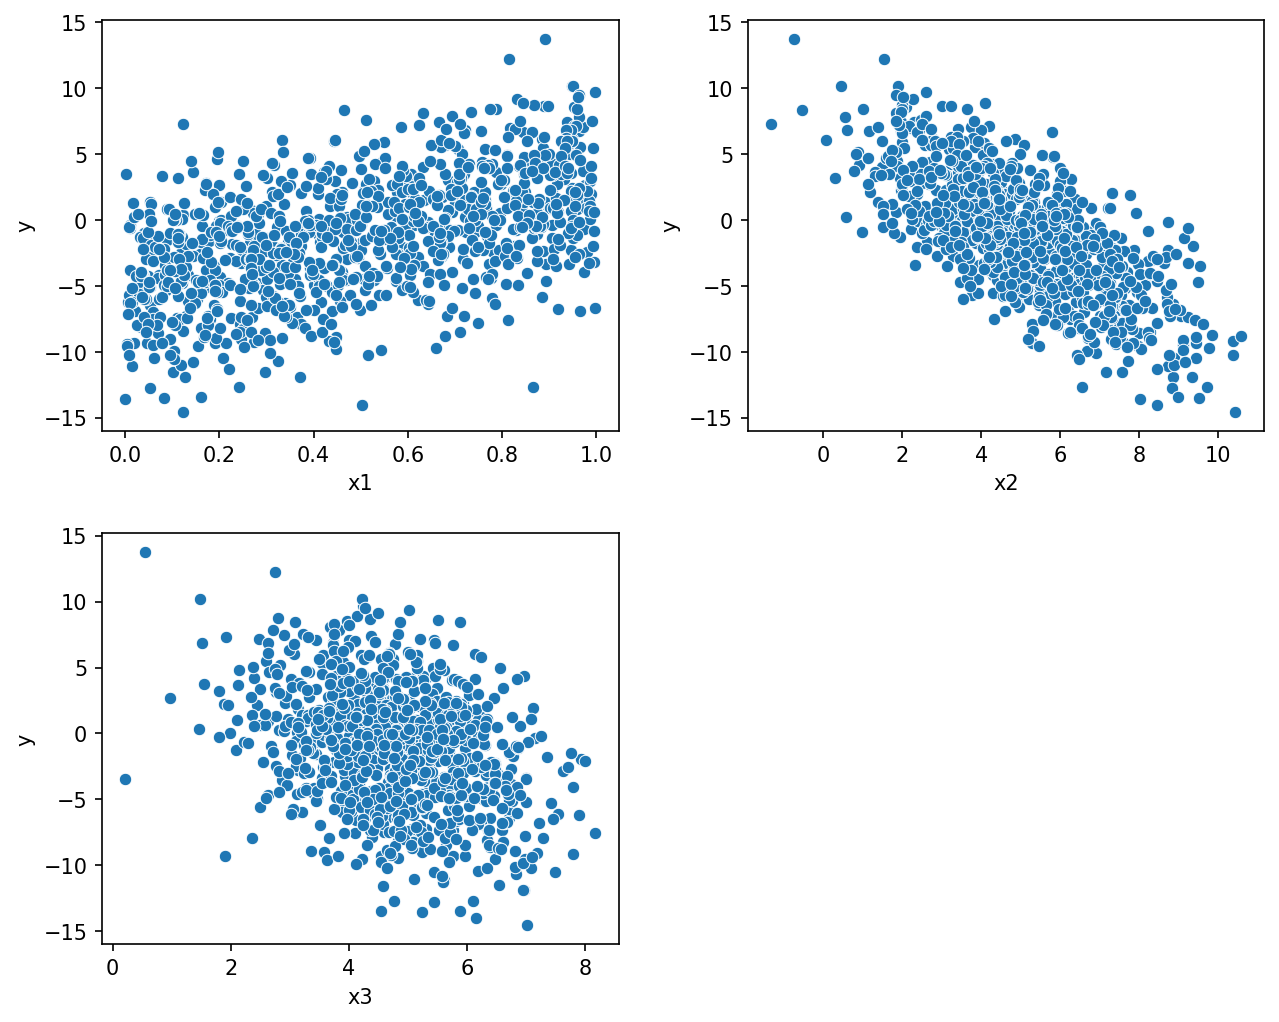

In [16]:
# rsm.scatter_plot(reg.fitted, ideal)
reg.plot("scatter")

The dashboard of six residual plots looks excellent, as we might expect for these data. True values and predicted values from the regression form a straight line with random scatter, i.e., as the actual values of the response variable go up, so do the predicted values from the model. The residuals (i.e., the differences between the values of the response variable data and the values predicted by the regression) show no pattern and are randomly scattered around a horizontal line. Any pattern would suggest that the model is better (or worse) at predicting some parts of the data compared to others. If a pattern were visible in the Residual vs Row order plot we might be concerned about auto-correlation. Again, the residuals are nicely scattered about a horizontal axis. Note that auto-correlation is a problem we are really only concerned about when we have time-series data. The Q-Q plot shows a nice straight and diagonal line, evidence that the residuals are normally distributed. This conclusion is confirmed by the histogram of the residuals and the density plot of the residuals (green) versus the theoretical density of a normally distributed variable (blue line).

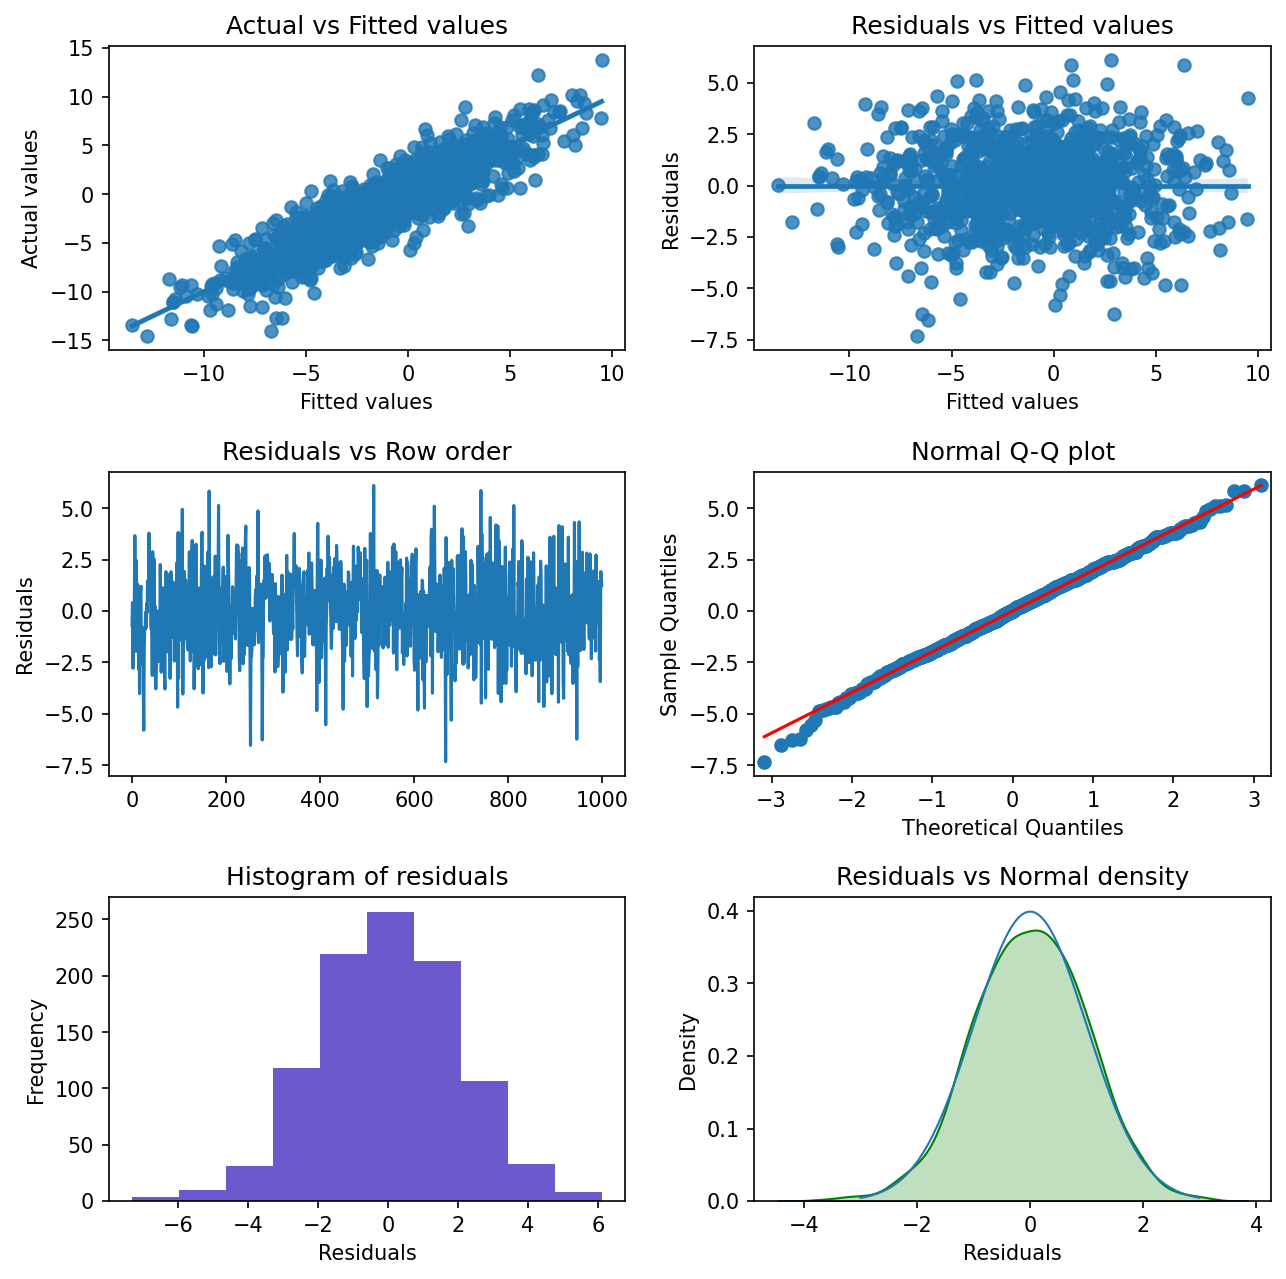

In [17]:
# rsm.reg_dashboard(reg.fitted, nobs=-1)
reg.plot("dashboard")

The final diagnostic we will discuss is a set of plots of the residuals versus the explanatory variables (or predictors). There is no indication of any trends or heteroscedasticity. Any patterns in these plots would be cause for concern. There are also no outliers, i.e., points that are far from the main cloud of data points.

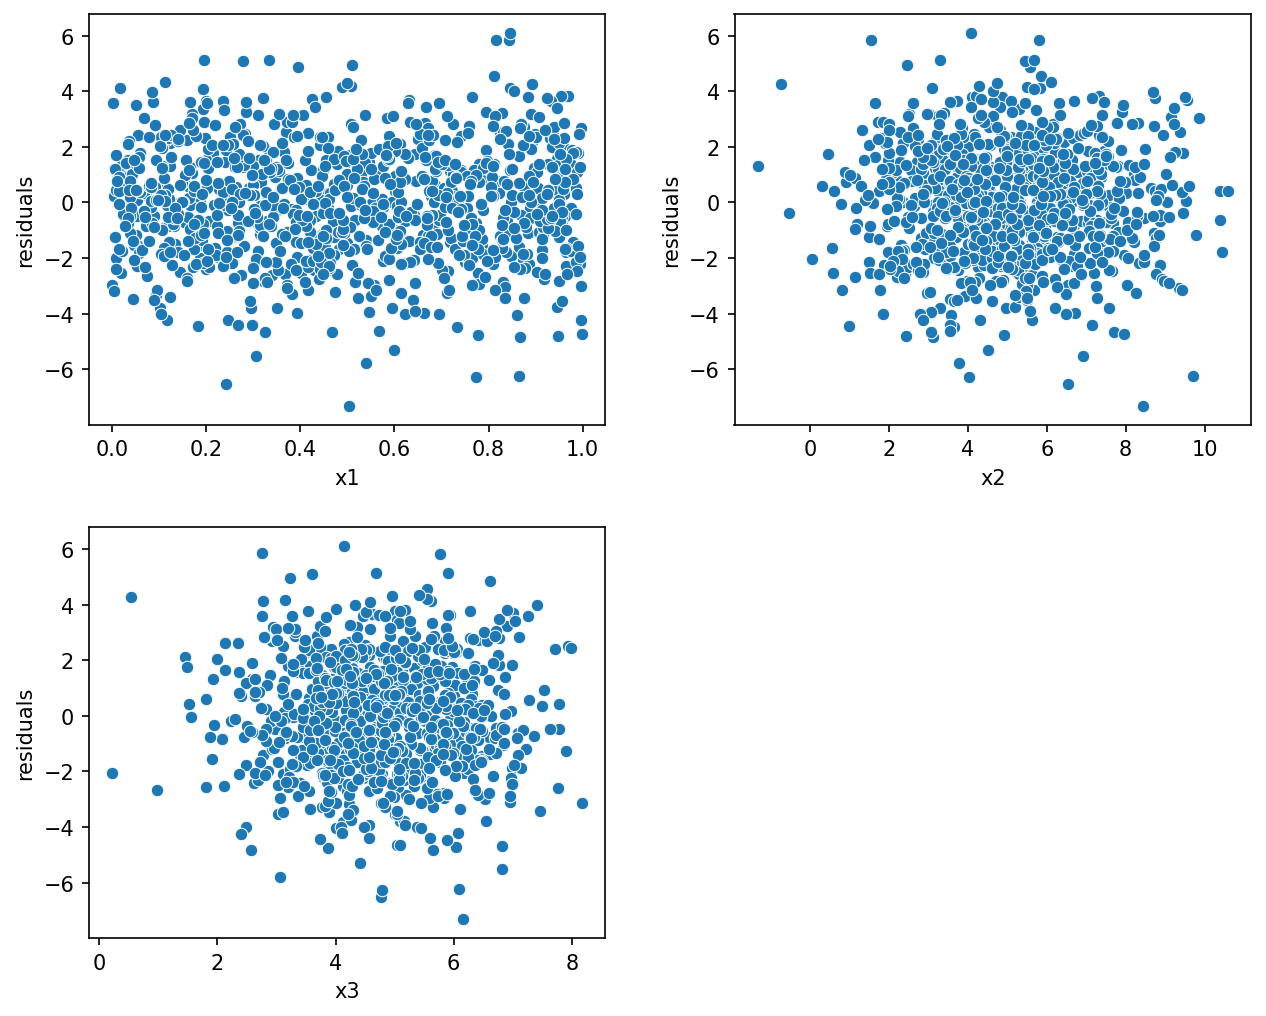

In [18]:
# rsm.residual_plot(reg.fitted, ideal)
reg.plot("residual")

Since the diagnostics look good, we can draw inferences from the regression. First, the model is significant as a whole: the p.value on the F-statistic is less than 0.05 therefore we reject the null hypothesis that all three variables in the regression have slope equal to zero. Second, each variable is statistically significant. For example, the p.value on the t-statistic for x1 is less than 0.05 therefore we reject the null hypothesis that x1 has a slope equal to zero when x2 and x3 are also in the model (i.e., ‘holding all other variables in the model constant’).

Increases in x1 and x3 are associated with increases in y whereas increases in x2 are associated with decreases in y. Since these are simulated data the exact interpretation of the coefficient is not very interesting. However, in the scatterplot it looks like increases in x3 are associated with decreases in y. What explains the difference? Hint: consider the correlation plots.

In [19]:
reg.summary(ssq=True)

Linear regression (OLS)
Data                 : Not provided
Response variable    : y
Explanatory variables: x1, x2, x3
Null hyp.: the effect of x on y is zero
Alt. hyp.: the effect of x on y is not zero

    index  coefficient  std.error  t.value p.value    
Intercept         0.67      0.279    2.398   0.017   *
       x1         7.71      0.213   36.157  < .001 ***
       x2        -1.99      0.043  -46.369  < .001 ***
       x3         0.90      0.070   12.861  < .001 ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-squared: 0.804, Adjusted R-squared: 0.803
F-statistic: 1360.646 df(3, 996), p.value < 0.001
Nr obs: 1,000

Sum of squares:

             df      SS
Regression    3  16,007
Error       996   3,905
Total       999  19,913


### Example 3: Linear or log-log regression?

Both linear and log-log regressions are commonly applied to business data. In this example we will look for evidence in the data and residuals that may suggest which model specification is  appropriate for the available data.

In [20]:
rsm.load_data(pkg="data", name="diamonds", dct=globals())

The data diamonds contains information on prices of 3,000 diamonds. A more complete description of the data and variables is available below.

In [21]:
rsm.describe(diamonds)

## Diamond prices

Prices of 3,000 round cut diamonds

### Description

A dataset containing the prices and other attributes of a sample of 3000 diamonds. The variables are as follows:

### Variables

- price = price in US dollars ($338--$18,791)
- carat = weight of the diamond (0.2--3.00)
- clarity = a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- cut = quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color = diamond color, from J (worst) to D (best)
- depth = total depth percentage = z / mean(x, y) = 2 * z / (x + y) (54.2--70.80)
- table = width of top of diamond relative to widest point (50--69)
- x = length in mm (3.73--9.42)
- y = width in mm (3.71--9.29)
- z = depth in mm (2.33--5.58)
- date = shipment date

### Additional information

<a href="http://www.diamondse.info/diamonds-clarity.asp" target="_blank">Diamond search engine</a>


 Select the variable price as the response variable and carat and clarity as the explanatory variables. Before looking at the parameter estimates from the regression go to the Plots tab to take a look at the data and residuals. Below are the histograms for the variables in the model. Price and carat seem skewed to the right. Note that the direction of skew is determined by where the tail is.

In [22]:
reg = rsm.regress(diamonds, rvar="price", evar=["carat", "clarity"])

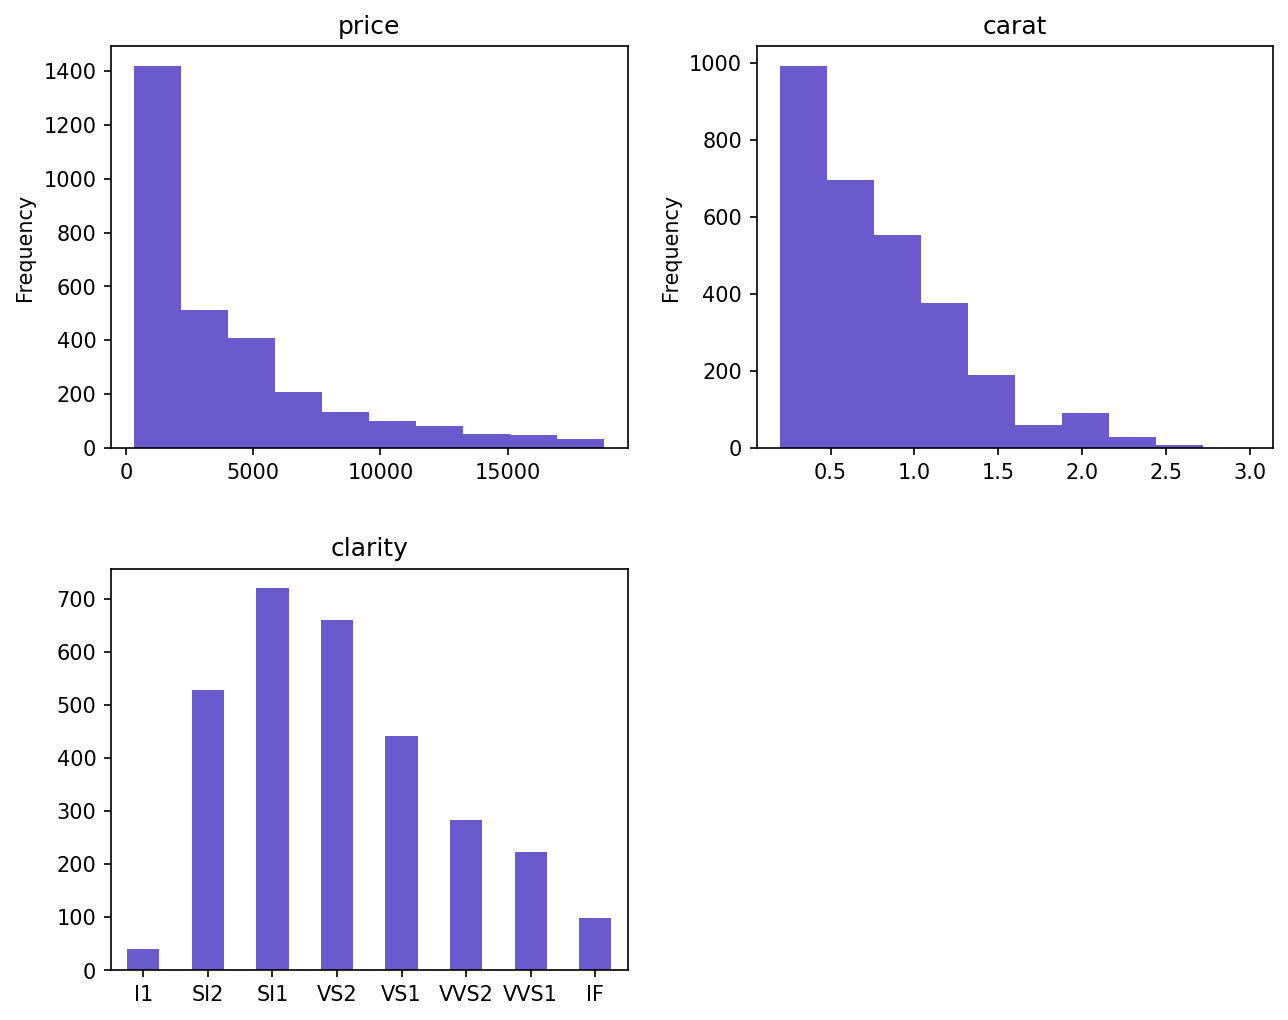

In [23]:
# rsm.distr_plot(diamonds, cols=["price", "carat", "clarity"])
reg.plot("distr")

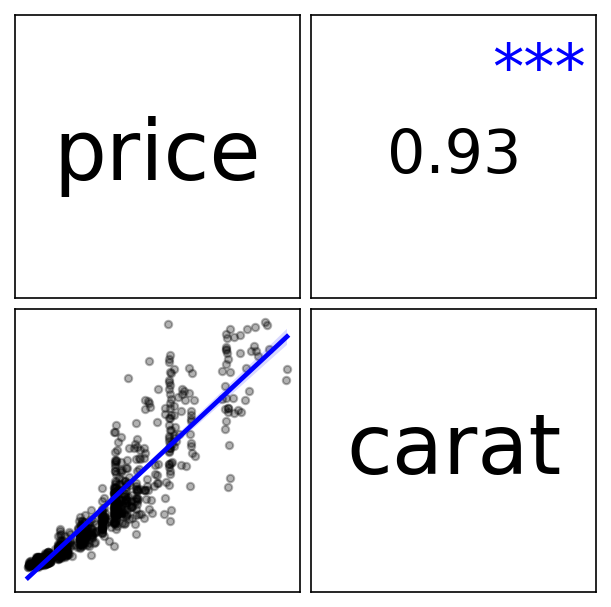

In [24]:
# cr = rsm.correlation(diamonds[["price", "carat"]])
# cr.plot(nobs=-1) # nobs=-1 to calculate correlation for all observations
reg.plot("corr")

The scatter plots of price (the response variable) against the explanatory variables are not as clean as for the ideal data in Example 2. The line fitted through the scatter plots is sufficiently flexible to pickup non-linearities. The line for carat seems to have some curvature and the points do not look randomly scattered around that line. In fact the points seem to fan-out for higher prices and number of carats. There does not seem to be very much movement in price for different levels of clarity. If anything, the price of the diamond seems to go down as clarity increase. A surprising result we will discuss in more detail below.

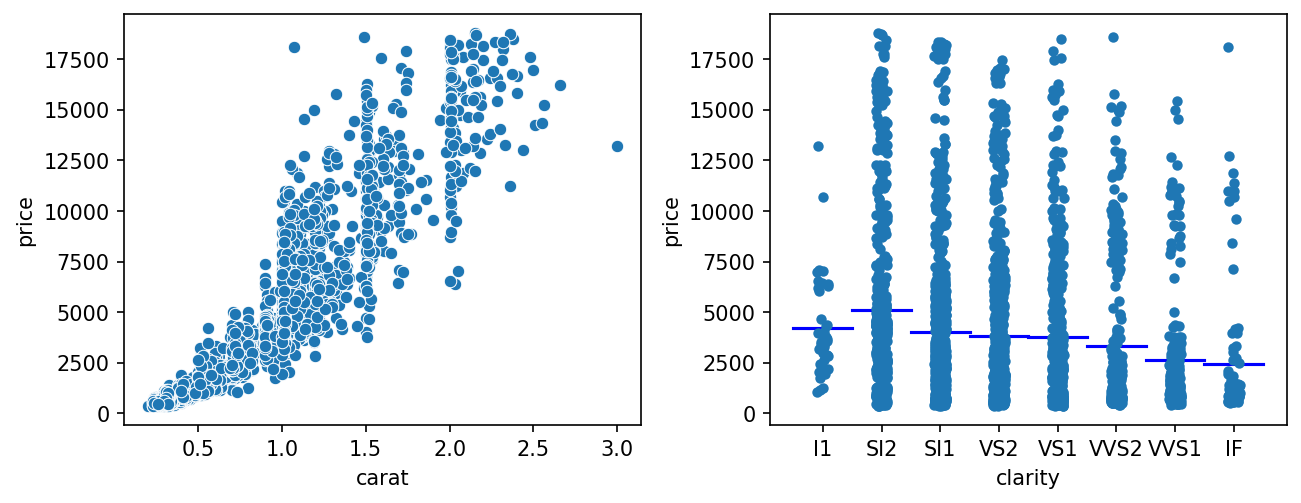

In [25]:
# rsm.scatter_plot(reg.fitted, diamonds, nobs=-1)
reg.plot("scatter", nobs=-1)

The dashboard of six residual plots looks less than stellar. The true values and predicted values from the regression form an S-shaped curve. At higher actual and predicted values the spread of points around the line is wider, consistent with what we saw in the scatter plot of price versus carat. The residuals (i.e., the differences between the actual data and the values predicted by the regression) show an even more distinct pattern as they are clearly not randomly scattered around a horizontal axis. The Residual vs Row order plot looks perfectly straight indicating that auto-correlation is not a concern. Finally, while for the ideal data in Example 2 the Q-Q plot showed a nice straight diagonal line, here dots clearly separate from the line at the right extreme. Evidence that the residuals are not normally distributed. This conclusions is confirmed by the histogram and density plots of the residuals that show a more spiked appearance than a normally distributed variable would.

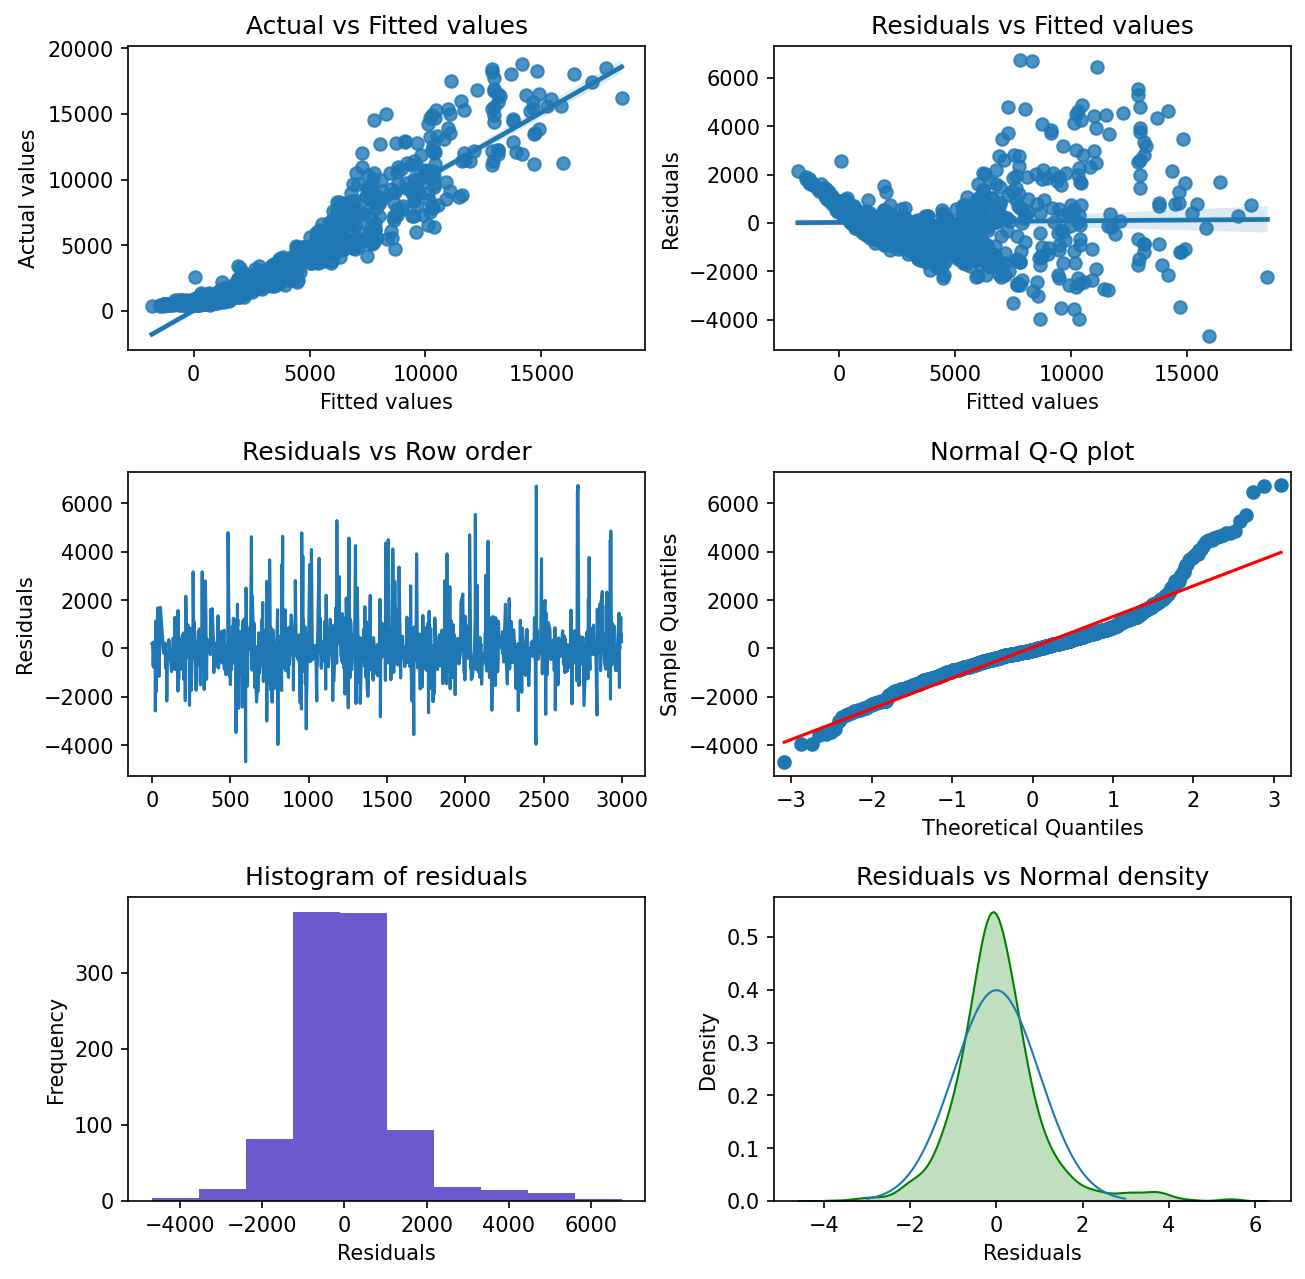

In [26]:
# rsm.reg_dashboard(reg.fitted)
reg.plot("dashboard")

The final diagnostic we will discuss is a set of plots of the residuals versus the explanatory variables (or predictors). The residuals fan-out from left to right in the plot of residuals vs carats. The scatter plot of `clarity` versus residuals shows outliers with strong negative values for lower levels of `clarity` and outliers with strong positive values for diamonds with higher levels of `clarity`.

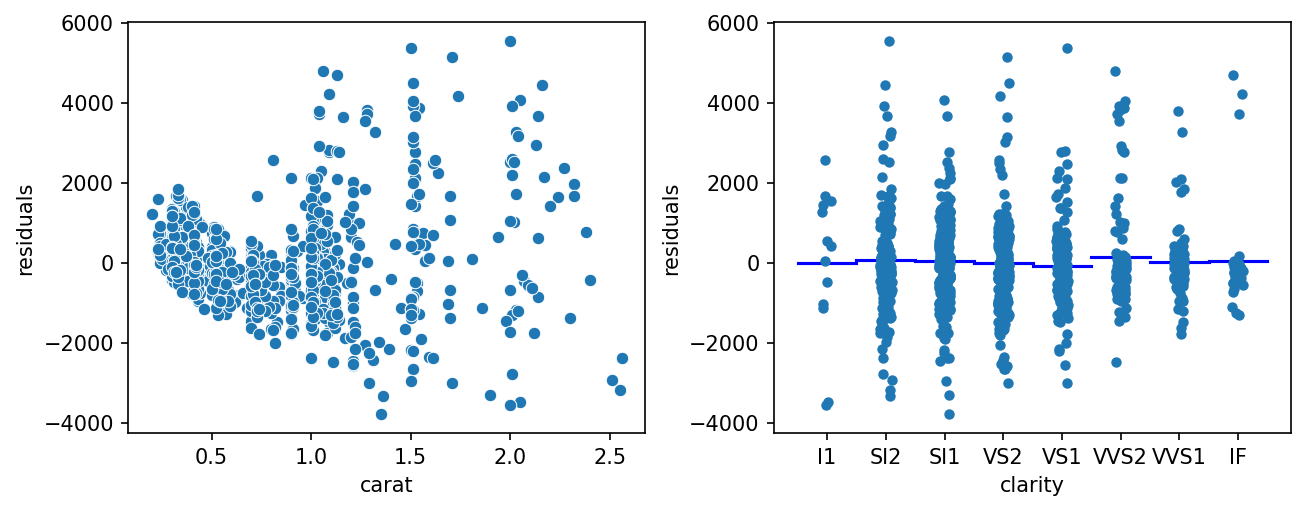

In [27]:
# rsm.residual_plot(reg.fitted, diamonds)
reg.plot("residual")

Since the diagnostics do not look good, we should not draw inferences from this regression. A log-log specification may be preferable.

In [28]:
diamonds = diamonds.assign(
    price_ln = np.log(diamonds.price),
    carat_ln = np.log(diamonds.carat)
)

In [29]:
reg = rsm.regress(diamonds, rvar="price_ln", evar=["carat_ln", "clarity"])

The relationship between log-price and log-carat looks close to linear. Exactly what we are looking for!

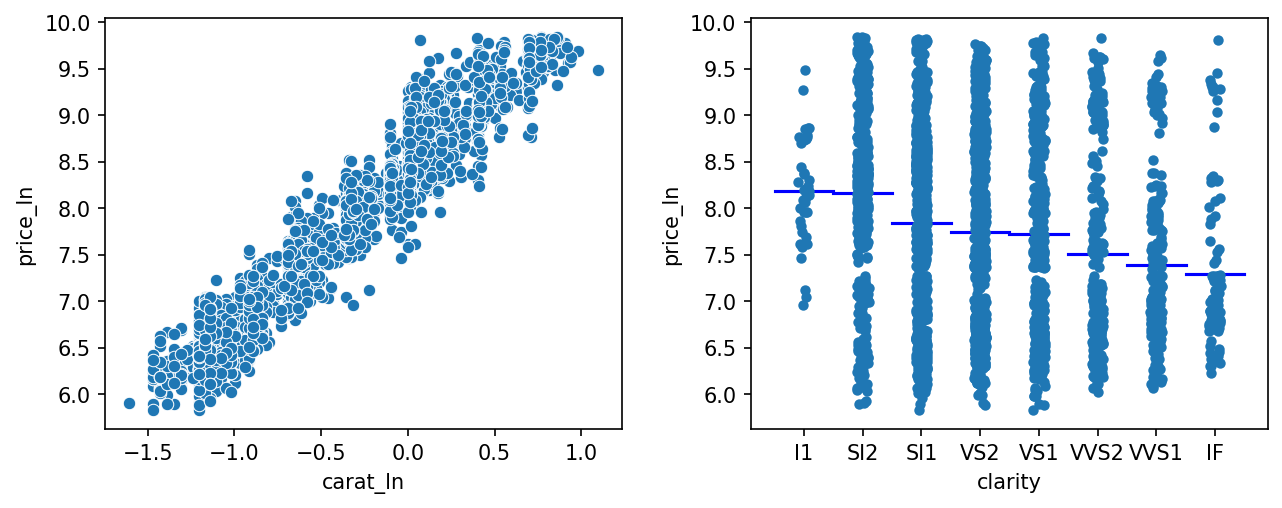

In [30]:
# rsm.scatter_plot(reg.fitted, diamonds, nobs=-1)
reg.plot("scatter", nobs=-1)

We will apply a (natural) log (or ln) transformation to both price and carat and rerun the analysis to see if the log-log specification is more appropriate for the available data. This transformation can be done in Data > Transform. Select the variables price and carat. Choose Transform from the Transformation type drop-down and choose Ln (natural log) from the Apply function drop-down. Make sure to click the Store button so the new variables are added to the dataset. Note that we cannot apply a log transformation to clarity because it is a categorical variable.

Specify `price_ln` as the response variable and `carat_ln` and `clarity` as the explanatory variables. Before looking at the parameter estimates from the regression lets take a look at the data and residuals. Below are the histograms for the variables in the model. Note that `price_ln` and `carat_ln` are no longer right skewed, a good sign.

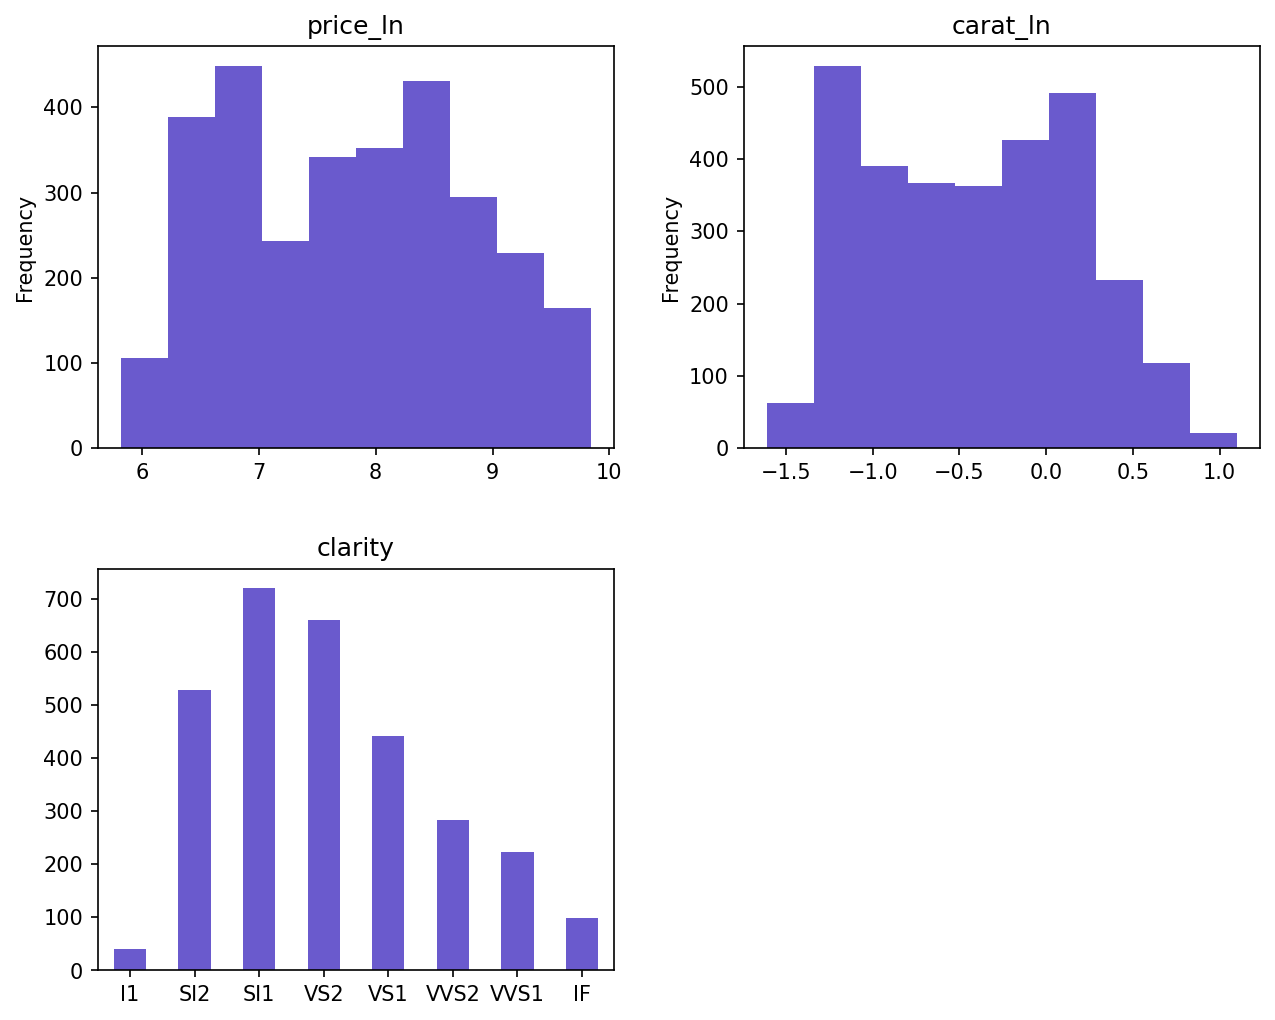

In [31]:
# rsm.distr_plot(diamonds, cols=["price_ln", "carat_ln", "clarity"])
reg.plot("distr")

In the plot of correlations there are still clear associations among the response and explanatory variables. The correlation between `price_ln` and `carat_ln` is extremely large (i.e., .93). The correlation between `carat_ln` and `clarity` of the diamond is significant and negative.

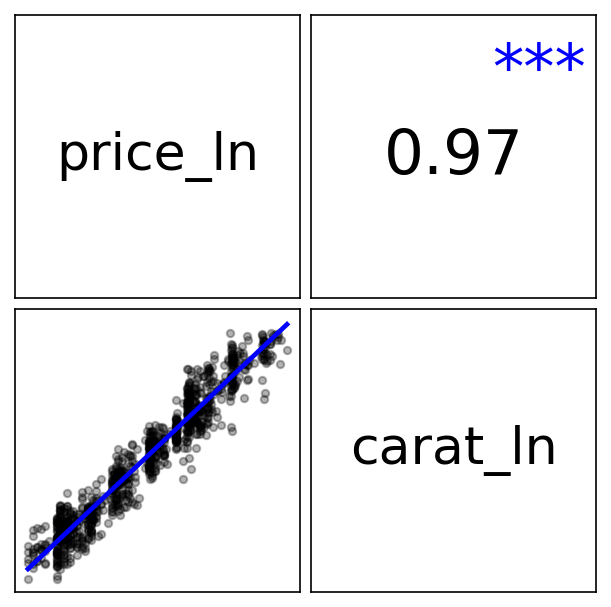

In [32]:
# cr = rsm.correlation(diamonds[["price_ln", "carat_ln", "clarity"]])
# cr.plot()
reg.plot("corr")

The scatter plots of price_ln (the response variable) against the explanatory variables are now much cleaner. The line through the scatter plot of price_ln versus carat_ln is (mostly) straight. Although the points do have a bit of a blocked shape around the line, the scattering seems mostly random. We no longer see the points fan-out for higher values of price_ln and carat_ln. There seems to be a bit more movement in price_ln for different levels of clarity. However, the price_ln of the diamond still goes down as clarity increases which is unexpected. We will discuss this result below.

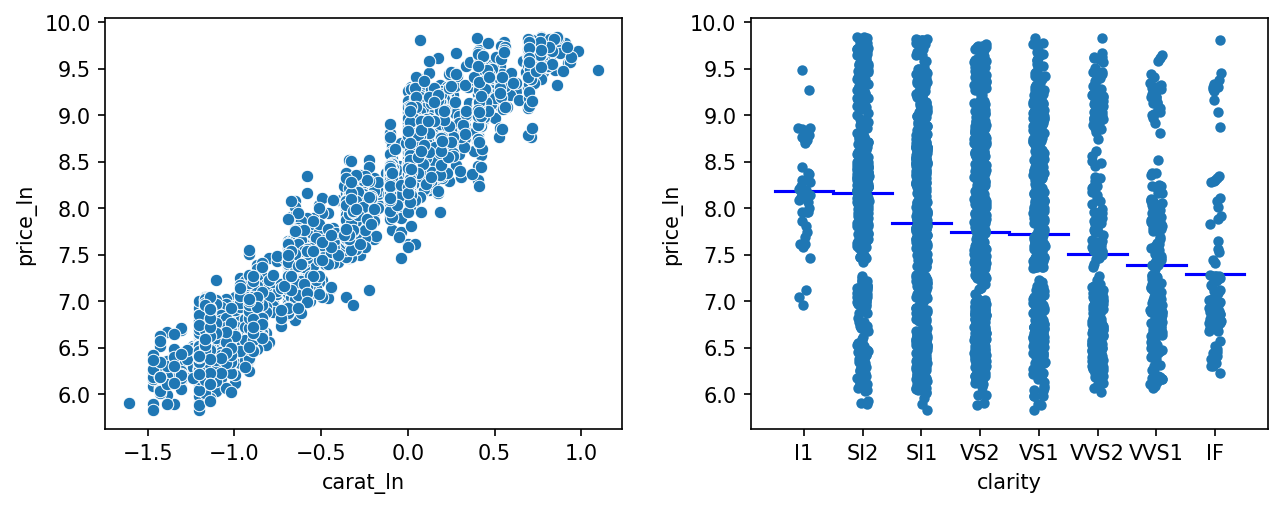

In [33]:
# rsm.scatter_plot(reg.fitted, diamonds, nobs=-1)
reg.plot("scatter", nobs=-1)

The dashboard of six residual plots looks much better than for the linear model. The true values and predicted values from the regression (almost) form a straight line. Although at higher and lower actual and predicted values the line is perhaps still very slightly curved. The residuals are much closer to a random scatter around a horizontal line. The Residual vs Row order plot still looks perfectly straight indicating that auto-correlation is not a concern. Finally, the Q-Q plot shows a nice straight and diagonal line, just like we saw for the ideal data in Example 2. Evidence that the residuals are now normally distributed. This conclusion is confirmed by the histogram and density plot of the residuals.

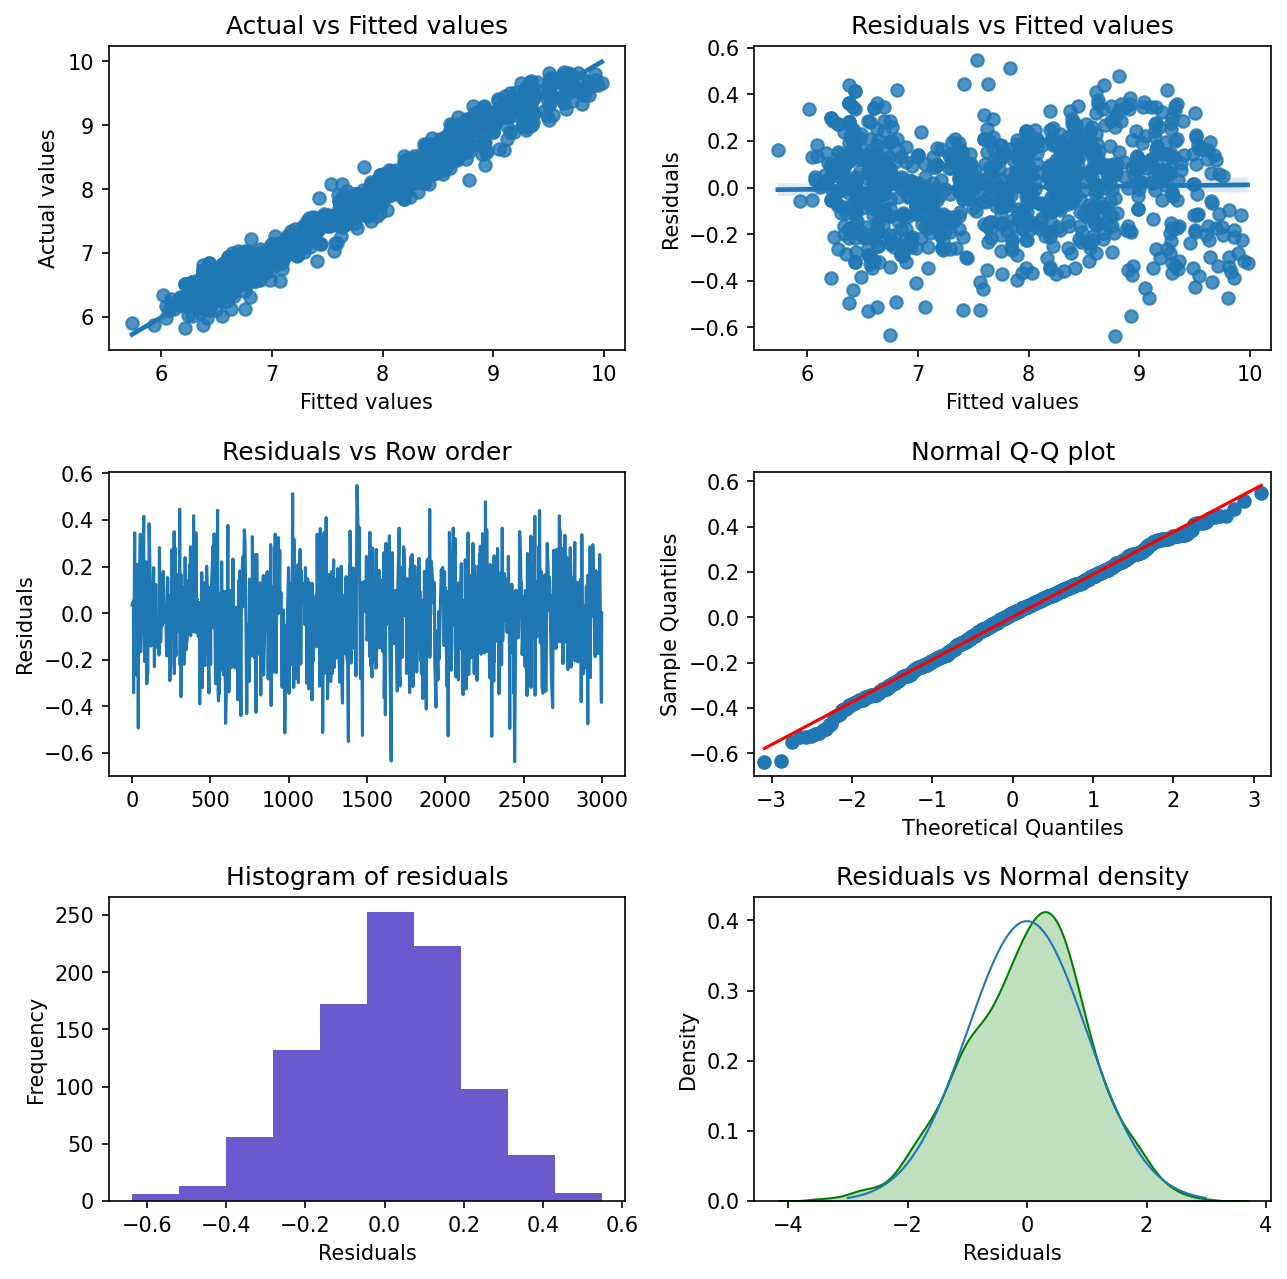

In [34]:
# rsm.reg_dashboard(reg.fitted)
reg.plot("dashboard")

The final diagnostic we will discuss is a set of plots of the residuals versus the explanatory variables (or predictors). The residuals look much closer to random scatter around a horizontal line compared to the linear model. Although for low (high) values of carat_ln the residuals may be a bit higher (lower).

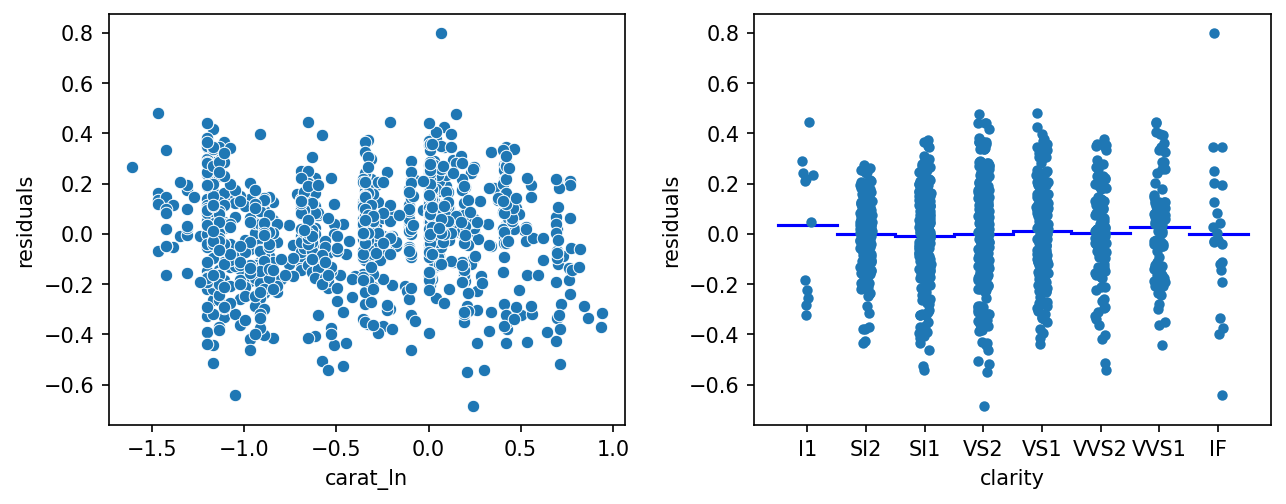

In [35]:
# rsm.residual_plot(reg.fitted, diamonds)
reg.plot("residual")

Since the diagnostics now look much better, we can feel more confident about drawing inferences from this regression. The regression results are available in the Summary tab. Note that we get 7 coefficients for the variable clarity compared to only one for carat_ln. How come? If you look at the data description (Data > Manage) you will see that clarity is a categorical variables with levels that go from IF (worst clarity) to I1 (best clarity). Categorical variables must be converted to a set of dummy (or indicator) variables before we can apply numerical analysis tools like regression. Each dummy indicates if a particular diamond has a particular clarity level (=1) or not (=0). Interestingly, to capture all information in the 8-level clarity variable we only need 7 dummy variables. Note there is no dummy variable for the clarity level I1 because we don’t actually need it in the regression. When a diamond is not of clarity SI2, SI1, VS2, VS1, VVS2, VVS1 or IF we know that in our data it must be of clarity I1.

The F-statistic suggests that the regression model as a whole explains a significant amount of variance in price_ln. The F-statistic is very large and has a very small p.value (< 0.001) so we can reject the null hypothesis that all regression coefficients are equal to zero. The amount of variance in price_ln explained by the model is equal to 96.6. It seems likely that prices of diamonds will be much easier to predict than demand for diamonds.

The null and alternate hypothesis for the F-test can be formulated as follows: H0: All regression coefficients are equal to 0 Ha: At least one regression coefficient is not equal to zero

The coefficients from the regression can be interpreted as follows:

* For a 1% increase in carats we expect, on average, to see a 1.809% increase in the price of a diamond of, keeping all other variables in the model constant
* Compared to a diamond of clarity I1 we expect, on average, to pay 100x(exp(.444)-1) = 55.89% more for a diamond of clarity SI2, keeping all other variables in the model constant
* Compared to a diamond of clarity I1 we expect, on average, to pay 100x(exp(.591)-1) = 80.58% more for a diamond of clarity SI1, keeping all other variables in the model constant
* Compared to a diamond of clarity I1 we expect, on average, to pay 100x(exp(1.080)-1) = 194.47% more for a diamond of clarity IF, keeping all other variables in the model constant

The coefficients for each of the levels of clarity imply that an increase in clarity will increase the price of diamond. Why then did the scatter plot of clarity versus (log) price show price decreasing with clarity? The difference is that in a regression we can determine the effect of a change in one variable (e.g., clarity) keeping all other variables in the model constant (i.e., carat). Bigger, heavier, diamonds are more likely to have flaws compared to small diamonds so when we look at the scatter plot we are really seeing the effect of not only improving clarity on price but also the effect of carats which are negatively correlated with clarity. In a regression, we can compare the effects of different levels of clarity on (log) price for a diamond of the same size (i.e., keeping carat constant). Without (log) carat in the model the estimated effect of clarity would be incorrect due to omitted variable bias. In fact, from a regression of price_ln on clarity we would conclude that a diamond of the highest clarity in the data (IF) would cost 59.22% less compared to a diamond of the lowest clarity (I1). Clearly this is not a sensible conclusion.

For each of the explanatory variables the following null and alternate hypotheses can be formulated: H0: The coefficient associated with explanatory variable X is equal to 0 Ha: The coefficient associated with explanatory variable X is not equal to 0

All coefficients in this regression are highly significant.

In [36]:
reg = rsm.regress(diamonds, rvar="price_ln", evar=["carat", "clarity"])
reg.summary(vif=True)

Linear regression (OLS)
Data                 : Not provided
Response variable    : price_ln
Explanatory variables: carat, clarity
Null hyp.: the effect of x on price_ln is zero
Alt. hyp.: the effect of x on price_ln is not zero

          index  coefficient  std.error  t.value p.value    
      Intercept         5.46      0.062   88.012  < .001 ***
 clarity[T.SI2]         0.44      0.061    7.274  < .001 ***
 clarity[T.SI1]         0.60      0.061    9.846  < .001 ***
 clarity[T.VS2]         0.71      0.061   11.560  < .001 ***
 clarity[T.VS1]         0.75      0.062   12.059  < .001 ***
clarity[T.VVS2]         0.80      0.064   12.552  < .001 ***
clarity[T.VVS1]         0.84      0.065   12.978  < .001 ***
  clarity[T.IF]         0.85      0.071   12.005  < .001 ***
          carat         2.09      0.015  135.086  < .001 ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-squared: 0.867, Adjusted R-squared: 0.866
F-statistic: 2433.202 df(8, 2991), p.value < 0.001
N

In [37]:
reg = rsm.regress(diamonds, rvar="price", evar=["carat", "clarity"])
reg.predict(ci=True, alpha=.1).round(3)

,carat,clarity,prediction,5.0%,95.0%
0,0.32,VS1,381.133,279.371,482.896
1,0.34,SI1,-303.531,-390.009,-217.054
2,0.30,VS2,0.322,-86.878,87.522
3,0.35,VVS2,1281.793,1160.374,1403.212
4,0.40,VS2,844.125,760.253,927.997
...,...,...,...,...,...
2995,1.14,SI1,6446.893,6367.921,6525.865
2996,1.51,SI1,9568.964,9475.579,9662.349
2997,0.32,VS2,169.083,82.603,255.562
2998,0.91,VS1,5359.571,5262.371,5456.771


In [38]:
reg.predict(df=diamonds.assign(carat=1)).round(3)

,carat,clarity,prediction
0,1,VS1,6118.994
1,1,SI1,5265.569
2,1,VS2,5906.943
3,1,VVS2,6766.513
4,1,VS2,5906.943
...,...,...,...
2995,1,SI1,5265.569
2996,1,SI1,5265.569
2997,1,VS2,5906.943
2998,1,VS1,6118.994


In [39]:
rsm.radiant_regress({"diamonds": diamonds, "diamonds100": diamonds.sample(100)})

INFO:     Started server process [64140]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:51331 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:51332 - "GET /bootstrap.bundle.min.js HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:51331 - "GET /bootstrap.min.css HTTP/1.1" 304 Not Modified


INFO:     ('127.0.0.1', 51333) - "WebSocket /websocket/" [accepted]
INFO:     connection open
INFO:     connection closed
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [64140]
